In [3]:
import pandas as pd
import plotly.express as px
import optuna
import numpy as np
from sklearn.model_selection import KFold
from asboostreg import SparseAdditiveBoostingRegressor
from utils import median_score
from pmlb import fetch_data

In [2]:
X, y = fetch_data("197_cpu_act", return_X_y=True)
cv = KFold()


def train_and_save_attributes(trial, params, scores, selections):
    model = SparseAdditiveBoostingRegressor(
        random_state=0,
        n_iter_no_change=15,
        max_bins=750,
        max_leaves=60,
        min_samples_leaf=15,
        n_estimators=4549,
        row_subsample=0.62,
        l2_regularization=0.89,
        learning_rate=params["learning_rate"],
        redundancy_exponent=params["redundancy_exponent"],
    )
    for i, (train_index, val_index) in enumerate(cv.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train, validation_set=(X_val, y_val))
        y_pred = model.predict(X_val)
        score = median_score(y_val, y_pred)
        scores[i] = score
        selections[i] = len(model.selection_count_)
    mean_score = np.mean(scores)
    model.fit(X, y)
    trial.set_user_attr("selection_count", np.median(selections))
    return mean_score


def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "redundancy_exponent": trial.suggest_float("redundancy_exponent", 0.0, 2.5),
    }
    scores = np.empty(5, dtype=np.float64)
    selections = np.empty(5, dtype=np.int64)
    custom_score = train_and_save_attributes(trial, params, scores, selections)
    return custom_score


study = optuna.create_study(direction='maximize')
study.optimize(
    objective, n_trials=100, timeout=3600, n_jobs=5
)

[I 2023-12-18 16:18:22,947] A new study created in memory with name: no-name-30935577-9f97-4da3-985e-83d53a4772ff
[I 2023-12-18 16:35:01,180] Trial 0 finished with value: 0.7656426076141962 and parameters: {'learning_rate': 0.25867755302039674, 'redundancy_exponent': 1.459659765118234}. Best is trial 0 with value: 0.7656426076141962.
[I 2023-12-18 16:38:17,622] Trial 3 finished with value: 0.7631126031014859 and parameters: {'learning_rate': 0.40551393199804087, 'redundancy_exponent': 1.9222558577915319}. Best is trial 0 with value: 0.7656426076141962.
[I 2023-12-18 16:42:35,875] Trial 1 finished with value: 0.7702553042230037 and parameters: {'learning_rate': 0.47726011789267603, 'redundancy_exponent': 0.5022001701109844}. Best is trial 1 with value: 0.7702553042230037.
[I 2023-12-18 16:45:51,625] Trial 4 finished with value: 0.7701001324771898 and parameters: {'learning_rate': 0.07853922395757883, 'redundancy_exponent': 1.7417947474657933}. Best is trial 1 with value: 0.7702553042230

In [9]:
#df = study.trials_dataframe()
df = pd.read_csv("../197_optuna_results.csv", index_col=False)

In [7]:
df.to_csv("../197_optuna_results.csv")

In [14]:
df.user_attrs_selection_count = df.user_attrs_selection_count.astype(str)
df

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_redundancy_exponent,user_attrs_selection_count,state
0,0,0,0.765643,2023-12-18 16:18:22.957141,2023-12-18 16:35:01.179736,0 days 00:16:38.222595,0.258678,1.459660,14.0,COMPLETE
1,1,1,0.770255,2023-12-18 16:18:22.959138,2023-12-18 16:42:35.875279,0 days 00:24:12.916141,0.477260,0.502200,16.0,COMPLETE
2,2,2,0.764799,2023-12-18 16:18:22.962139,2023-12-18 16:46:02.759845,0 days 00:27:39.797706,0.013018,1.709406,12.0,COMPLETE
3,3,3,0.763113,2023-12-18 16:18:22.965140,2023-12-18 16:38:17.620513,0 days 00:19:54.655373,0.405514,1.922256,14.0,COMPLETE
4,4,4,0.770100,2023-12-18 16:18:22.966141,2023-12-18 16:45:51.624350,0 days 00:27:28.658209,0.078539,1.741795,14.0,COMPLETE
5,5,5,0.762022,2023-12-18 16:35:01.199741,2023-12-18 17:03:01.701530,0 days 00:28:00.501789,0.008599,1.414043,12.0,COMPLETE
6,6,6,0.769621,2023-12-18 16:38:17.628516,2023-12-18 17:05:11.889067,0 days 00:26:54.260551,0.039454,1.628056,14.0,COMPLETE
7,7,7,0.765278,2023-12-18 16:42:35.891284,2023-12-18 17:09:06.505739,0 days 00:26:30.614455,0.319094,1.644454,14.0,COMPLETE
8,8,8,0.768161,2023-12-18 16:45:51.634353,2023-12-18 17:12:22.254042,0 days 00:26:30.619689,0.419478,0.857147,16.0,COMPLETE
9,9,9,0.767001,2023-12-18 16:46:02.767846,2023-12-18 17:13:39.166269,0 days 00:27:36.398423,0.232013,1.825510,14.0,COMPLETE


In [15]:
def plot_param_vals(df_input, color_column, column_name):
    """
    plt.scatter(
        x=df_input["params_learning_rate"],
        y=df_input["params_redundancy_exponent"],
        c=df_input[color_column],
        alpha=0.3,
        cmap="tab10",
    )
    plt.colorbar()
    plt.xlabel("learning_rate")
    plt.ylabel("redundancy_exponent")
    plt.title(f"Efecto de los parámetros sobre {column_name}")
    plt.savefig(fr"../plots/{column_name}.png")
    plt.show()
    """
    fig = px.scatter(
        df_input,
        x="params_learning_rate",
        y="params_redundancy_exponent",
        color=color_column,
        title=f"Efecto de los parámetros sobre {column_name}",
        labels={
            "params_learning_rate": "learning_rate",
            "params_redundancy_exponent": "redundancy_exponent",
            color_column: "",
        },
    )
    #fig.write_image(fr"../plots/197_{column_name}.png")
    fig.show()

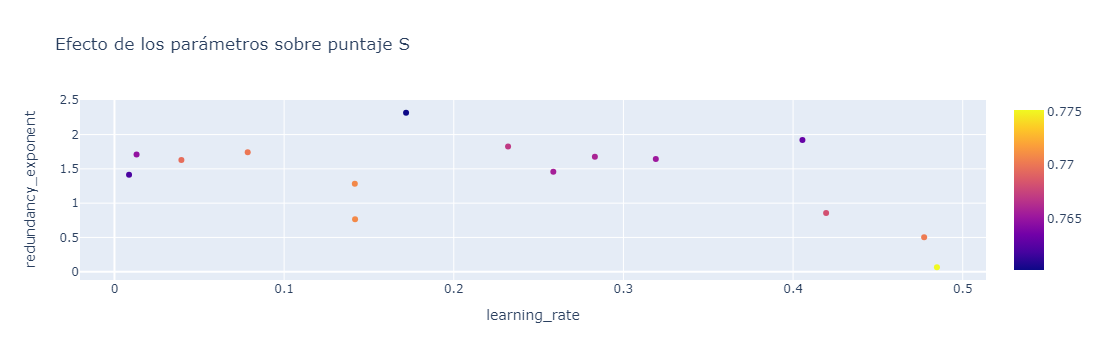

In [16]:
plot_param_vals(
    df, "value", "puntaje S"
)

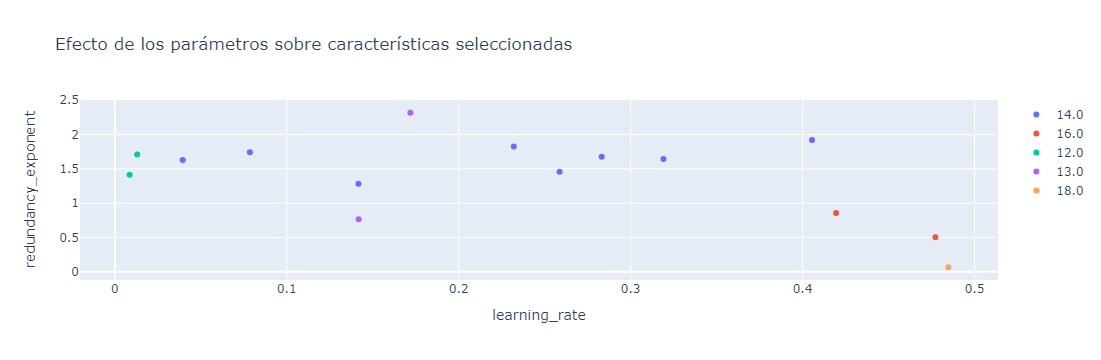

In [17]:
plot_param_vals(
    df, "user_attrs_selection_count", "características seleccionadas"
)

In [ ]:
!)